## **16. 회귀 예제: 보스턴 주택 가격 예측**

### **1. 데이터프레임 생성**

In [1]:
# SparkSession 설정
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master('local') \
    .appName('housing-prices-regression') \
    .getOrCreate()

In [2]:
# [+] 주택 가격 데이터에 대한 DataFrame 생성
path = './data/'
file = 'boston.csv'

house_df = spark.read.csv(path + file, inferSchema=True, header=True)

In [3]:
# [+] 데이터프레임 출력
house_df.show()

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+---------+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM|  AGE|   DIS|RAD|TAX|PTRATIO|     B|LSTAT|MEDV|CAT. MEDV|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+---------+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|        0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|        0|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|        1|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|        1|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|        1|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|        0|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|        0|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|

In [4]:
# [+] 데이터프레임 스키마 출력
house_df.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MEDV: double (nullable = true)
 |-- CAT. MEDV: integer (nullable = true)



In [5]:
# 캐싱하기: DataFrame 을 메모리에 저장
house_df.cache()

DataFrame[CRIM: double, ZN: double, INDUS: double, CHAS: int, NOX: double, RM: double, AGE: double, DIS: double, RAD: int, TAX: int, PTRATIO: double, B: double, LSTAT: double, MEDV: double, CAT. MEDV: int]

In [6]:
# [+] 기술 통계량 출력(보기 불편함)
house_df.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|              CRIM|                ZN|             INDUS|              CHAS|                NOX|                RM|               AGE|              DIS|              RAD|               TAX|           PTRATIO|                 B|             LSTAT|              MEDV|          CAT. MEDV|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|               506|               506|               506|               506|                506|          

In [7]:
# [+] pandas DataFrame 의 형태로 변환하여 출력
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CRIM,506,3.6135235573122535,8.601545105332491,0.00632,88.9762
ZN,506,11.363636363636363,23.32245299451514,0.0,100.0
INDUS,506,11.136778656126504,6.860352940897589,0.46,27.74
CHAS,506,0.0691699604743083,0.2539940413404101,0,1
NOX,506,0.5546950592885372,0.11587767566755584,0.385,0.871
RM,506,6.284634387351787,0.7026171434153232,3.561,8.78
AGE,506,68.57490118577078,28.148861406903595,2.9,100.0
DIS,506,3.795042687747034,2.10571012662761,1.1296,12.1265
RAD,506,9.549407114624506,8.707259384239366,1,24


### **2. 탐색적 데이터 분석(EDA: Exploratory Data Analysis)**

In [8]:
# [+] EDA를 위해 pandas DataFrame 으로 변환
house_pdf = house_df.toPandas()

In [9]:
house_pdf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,1


In [10]:
# Seaborn (시각화 라이브러리) 설치
!pip install seaborn

In [11]:
# seaborn 시각화 라이브러리 임포트 및 설정
import seaborn as sns

sns.set()  # set plot 스타일 적용
sns.set_style("whitegrid")

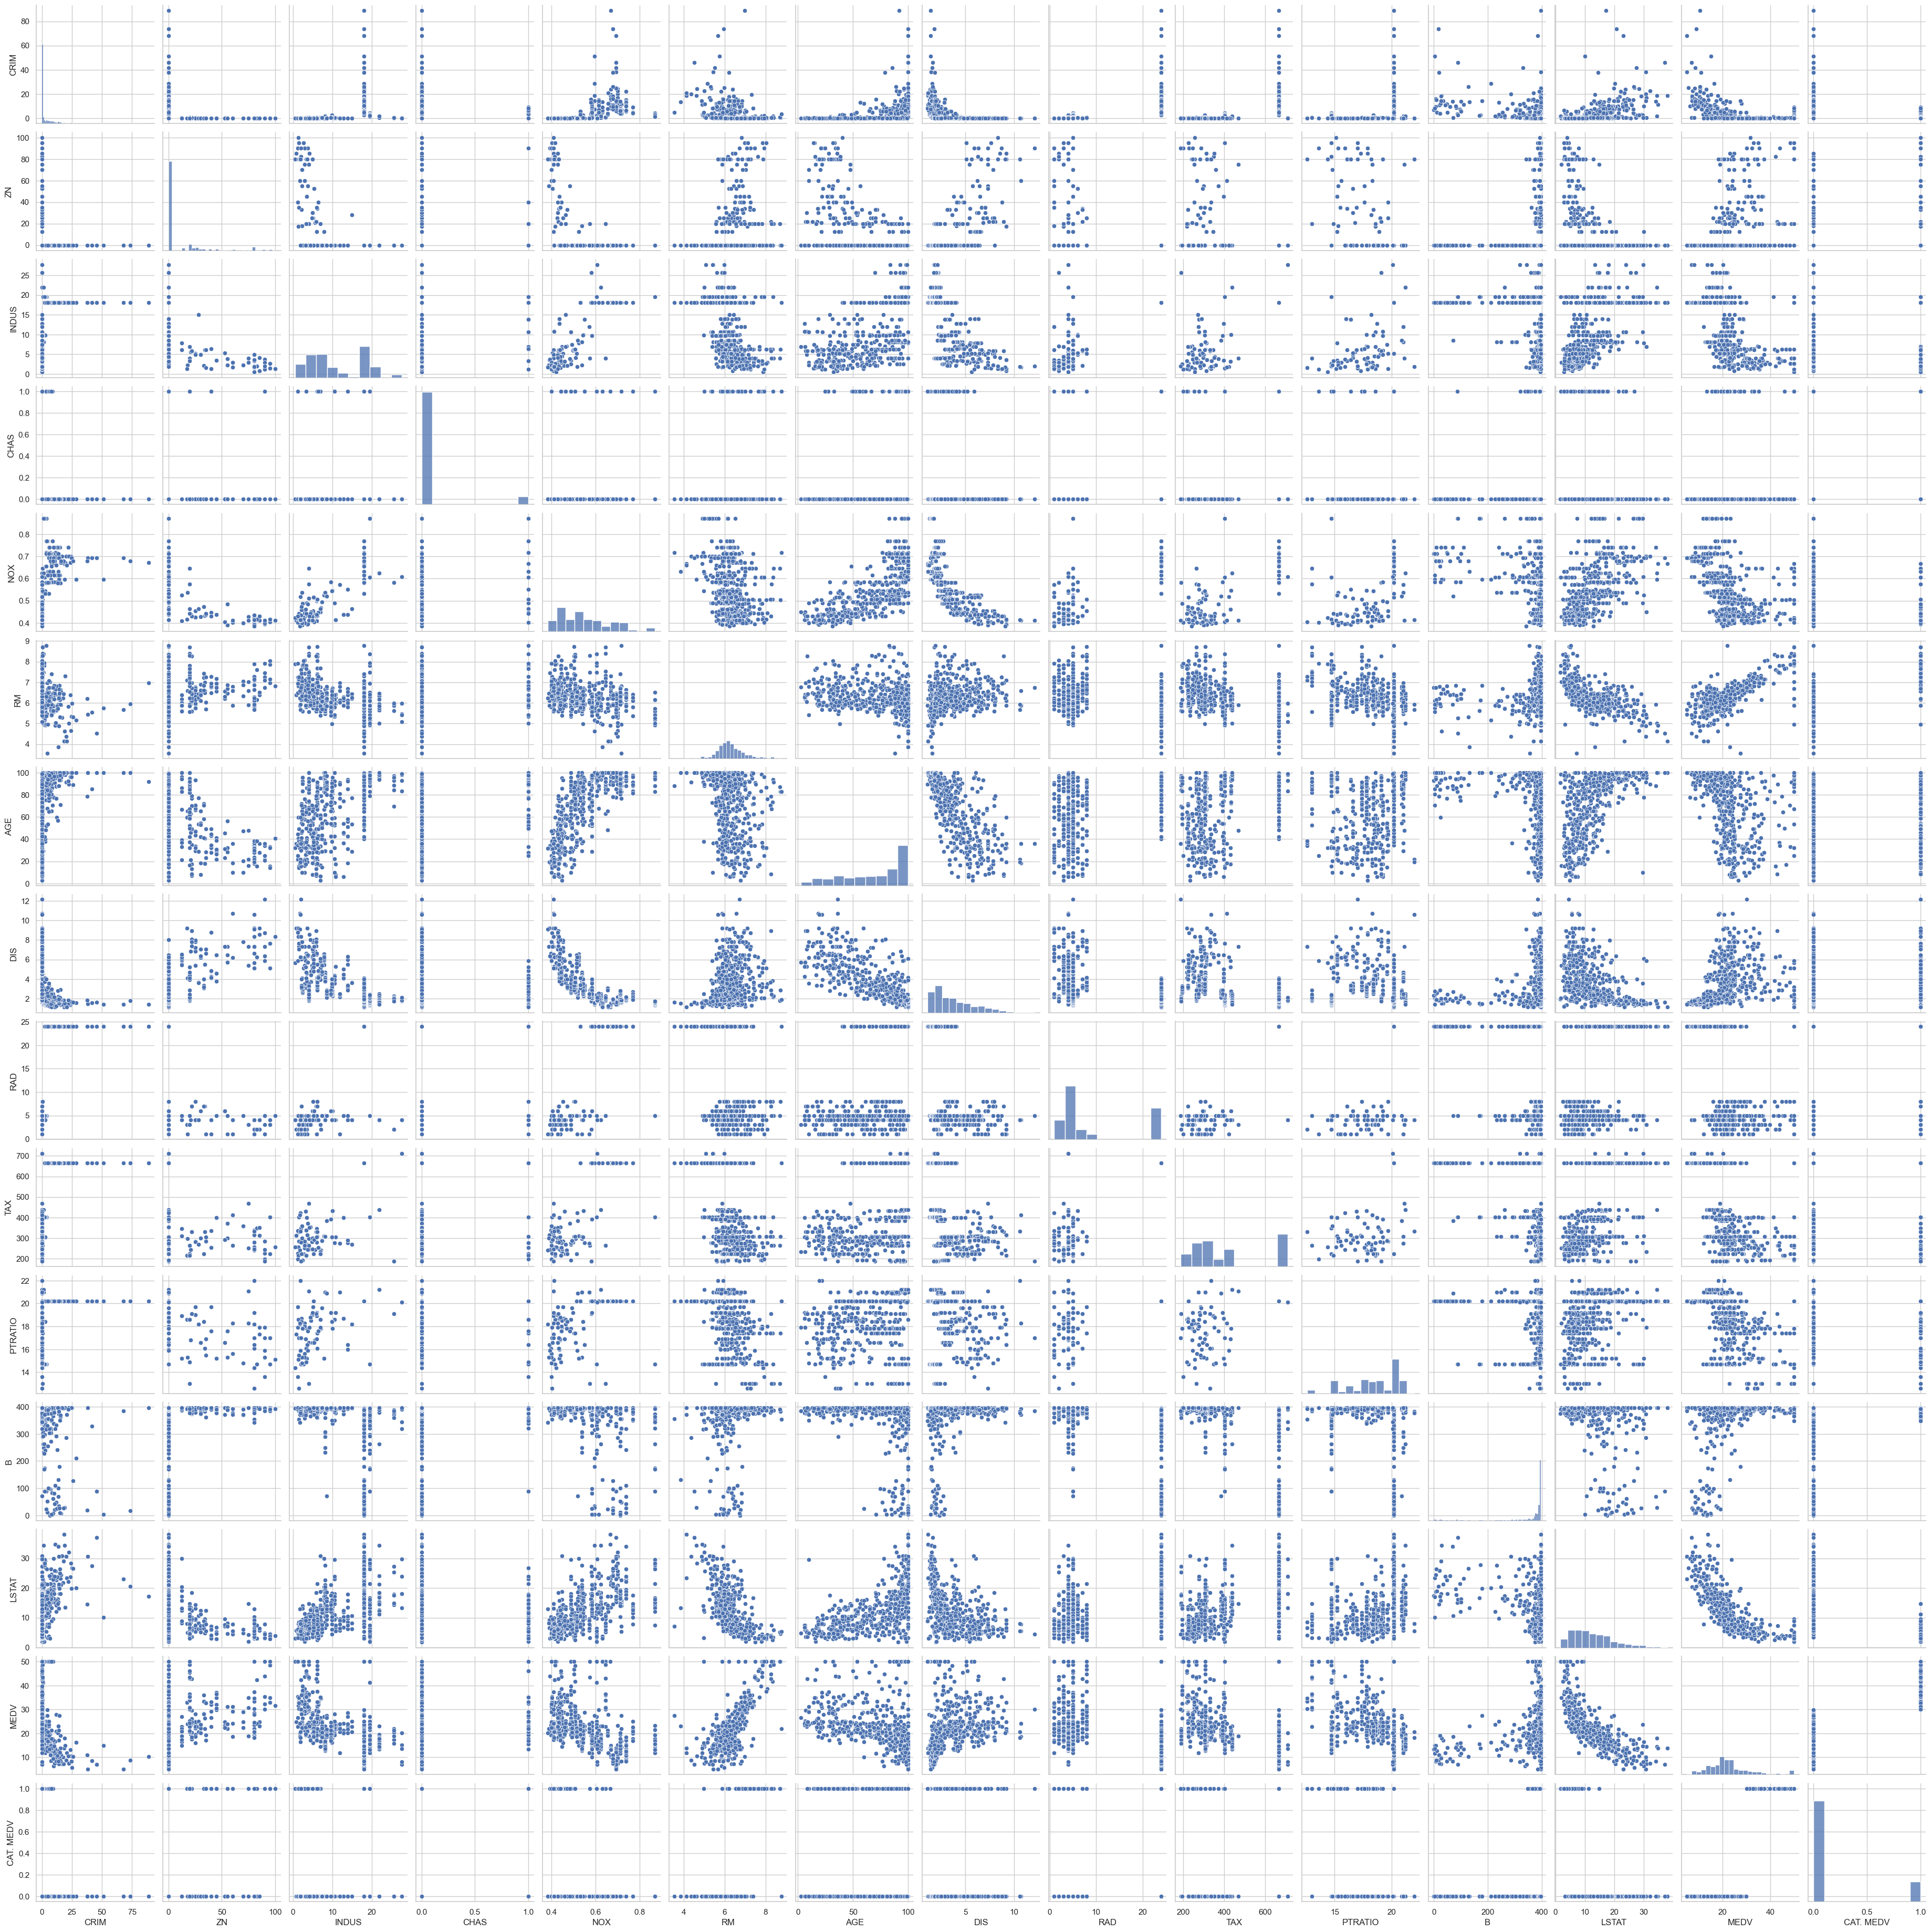

In [12]:
# [+] 변수별 상관관계 시각화
sns.pairplot(house_pdf)

In [13]:
# [+] 변수간 상관계수 출력
house_pdf.corr(method='pearson')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305,-0.151987
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445,0.365296
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725,-0.366276
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260,0.108631
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321,-0.232502
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360,0.641265
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955,-0.191196
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929,0.118887
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626,-0.197924
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536,-0.273687


In [14]:
# [+] 목표 변수와의 상관계수 출력
house_pdf.corr(method='pearson')['MEDV']

CRIM        -0.388305
ZN           0.360445
INDUS       -0.483725
CHAS         0.175260
NOX         -0.427321
RM           0.695360
AGE         -0.376955
DIS          0.249929
RAD         -0.381626
TAX         -0.468536
PTRATIO     -0.507787
B            0.333461
LSTAT       -0.737663
MEDV         1.000000
CAT. MEDV    0.789789
Name: MEDV, dtype: float64

In [15]:
# VectorAssember: DataFrame의 컬럼들을 특징 벡터(feature vector)로 변환
from pyspark.ml.feature import VectorAssembler

In [16]:
# 특징 벡터화 하고자 하는 변수들을 선택
vectorAssembler = VectorAssembler(inputCols=[
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
    'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'],
    outputCol = 'features')


In [17]:
# [+] 특징 벡터화된 새로운 DataFrame으로 변환
vhouse_df = vectorAssembler.transform(house_df)

In [18]:
vhouse_df.toPandas()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV,features
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0,"[0.00632, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2,..."
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0,"[0.02731, 0.0, 7.07, 0.0, 0.469, 6.421, 78.9, ..."
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,1,"[0.02729, 0.0, 7.07, 0.0, 0.469, 7.185, 61.1, ..."
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,1,"[0.03237, 0.0, 2.18, 0.0, 0.458, 6.998, 45.8, ..."
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,1,"[0.06905, 0.0, 2.18, 0.0, 0.458, 7.147, 54.2, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4,0,"[0.06263, 0.0, 11.93, 0.0, 0.573, 6.593, 69.1,..."
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6,0,"[0.04527, 0.0, 11.93, 0.0, 0.573, 6.12, 76.7, ..."
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9,0,"[0.06076, 0.0, 11.93, 0.0, 0.573, 6.976, 91.0,..."
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0,0,"[0.10959, 0.0, 11.93, 0.0, 0.573, 6.794, 89.3,..."


In [19]:
# [+] 데이터프레임에서 'features'와 'MEDV' 컬럼 선택
vhouse_df = vhouse_df.select(['features','MEDV'])

In [20]:
vhouse_df.show()

+--------------------+----+
|            features|MEDV|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
|[0.22489,12.5,7.8...|15.0|
|[0.11747,12.5,7.8...|18.9|
|[0.09378,12.5,7.8...|21.7|
|[0.62976,0.0,8.14...|20.4|
|[0.63796,0.0,8.14...|18.2|
|[0.62739,0.0,8.14...|19.9|
|[1.05393,0.0,8.14...|23.1|
|[0.7842,0.0,8.14,...|17.5|
|[0.80271,0.0,8.14...|20.2|
|[0.7258,0.0,8.14,...|18.2|
+--------------------+----+
only showing top 20 rows



In [21]:
# [+] 훈련/테스트 데이터셋을 7대3 비율로 구성
train_df, test_df = vhouse_df.randomSplit([0.7,0.3])

### **3. 선형회귀 모델 학습**

In [22]:
# 선형회귀 학습 알고리즘 임포트
from pyspark.ml.regression import LinearRegression

#### 선형회귀 모델 매개변수 설정
+ ```featureCol```: 특징 컬럼
+ ```labelCol```: 레이블 컬럼
+ ```maxIter```: 최대 학습 횟수
+ ```regParam```: 정규화 매개변수
+ ```elasticNetParam```: 정규화 매개변수2

In [23]:
# 선형회귀 학습 알고리즘 객체 생성 및 매개변수 설정
lr = LinearRegression(
    featuresCol = 'features', 
    labelCol='MEDV', 
    maxIter=10, 
    regParam=0.3, 
    elasticNetParam=0.8)

In [24]:
# [+] 모델 학습
model = lr.fit(train_df)

In [25]:
# 회귀계수(가중치)와 intercept(bias) 값 출력
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

Coefficients: [-0.01459632053916076,0.0002222180309871812,-0.052768947179989416,3.21786535114547,-0.9819614693913892,3.820559774361305,0.0,-0.4149947251804706,0.022396160071583755,0.0,-0.6679815165991424,0.011399058683432477,-0.6066185312084296]
Intercept: 16.703852938271897


In [26]:
# 모델 학습결과 출력
trainingSummary = model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.867789
r2: 0.709476


In [27]:
train_df.describe().show()

+-------+------------------+
|summary|              MEDV|
+-------+------------------+
|  count|               334|
|   mean|22.147604790419166|
| stddev| 9.044649519822947|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [28]:
# [+] train 데이터에 대한 모델 예측값 생성 (모델의 학습 성능을 평가하기 위함)
predictions = model.transform(train_df)

In [29]:
# 레이블과 예측 값
y_train = predictions.toPandas()['MEDV']
y_hat_train = predictions.toPandas()['prediction']

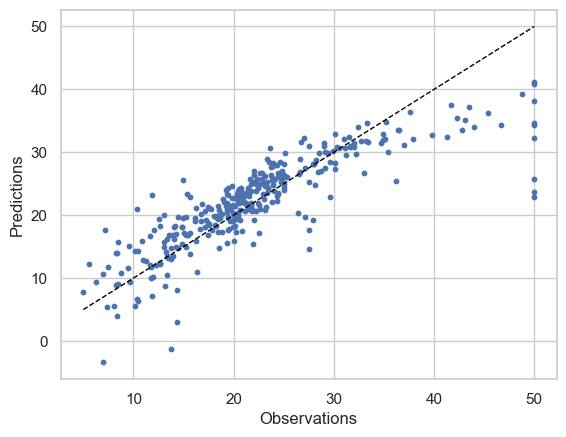

In [30]:
# 산점도 시각화
from matplotlib import pyplot as plt

# scatter plot
fig, ax = plt.subplots()
ax.scatter(y_train, y_hat_train, 10)   # 10: marker size
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', lw=1, color='black')
ax.set_xlabel('Observations')
ax.set_ylabel('Predictions')
plt.show()

In [33]:
# [+] test 데이터에 대한 모델 예측값 생성
predictions = model.transform(test_df)

In [34]:
predictions.select("prediction","MEDV","features").show()

+------------------+----+--------------------+
|        prediction|MEDV|            features|
+------------------+----+--------------------+
|30.786026228144046|24.0|[0.00632,18.0,2.3...|
|  27.1460279679809|22.0|[0.01096,55.0,2.2...|
|17.083570460544482|18.9|[0.0136,75.0,4.0,...|
|  37.1884640355034|50.0|[0.01381,80.0,0.4...|
| 27.63149244080747|24.5|[0.01501,80.0,2.0...|
|30.727685150683797|32.9|[0.01778,95.0,1.4...|
| 37.72018703423822|50.0|[0.02009,95.0,2.6...|
|26.367425345194903|24.7|[0.02055,85.0,0.7...|
| 27.08024612734298|16.5|[0.02498,0.0,1.89...|
| 25.47484627966865|21.6|[0.02731,0.0,7.07...|
| 28.83167605147594|30.8|[0.02763,75.0,2.9...|
|30.193095426246508|34.9|[0.0315,95.0,1.47...|
| 30.64998824183474|33.4|[0.03237,0.0,2.18...|
|  23.0475770189823|20.6|[0.03306,0.0,5.19...|
|21.373937089268228|19.5|[0.03427,0.0,5.19...|
| 27.35421618977812|24.1|[0.03445,82.5,2.0...|
| 36.48971129114774|48.5|[0.0351,95.0,2.68...|
| 27.01337438640601|22.0|[0.03537,34.0,6.0...|
| 24.64940646

In [35]:
# 모델 성능 측정(결정계수)을 위한 evaluator 생성
from pyspark.ml.evaluation import RegressionEvaluator

r2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MEDV", metricName="r2")

In [36]:
# 결정계수 측정 및 출력
r2 = r2_evaluator.evaluate(predictions)
print("R Squared (R2) on test data = %g" % r2)

R Squared (R2) on test data = 0.698043


In [37]:
# 모델 성능 측정(RMSE)을 위한 evaluator 생성
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MEDV", metricName="rmse")

In [38]:
# RMSE 측정 및 출력

rmse = rmse_evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.18762


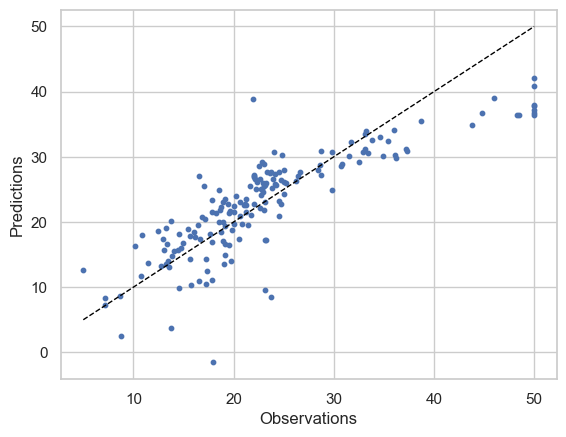

In [39]:
# 산점도 시각화
y_train = predictions.toPandas()['MEDV']
y_hat_train = predictions.toPandas()['prediction']

fig, ax = plt.subplots()
ax.scatter(y_train, y_hat_train, 10)   # 10: marker size
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', lw=1, color='black')
ax.set_xlabel('Observations')
ax.set_ylabel('Predictions')
plt.show()